In [1]:
# Import analysis packages
%matplotlib inline
import stan as ps
from patsy import dmatrix
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats

# Importing nest_asyncio is only necessary to run pystan in Jupyter Notebooks.
import nest_asyncio
nest_asyncio.apply();

In [2]:
# Notebook formatting (code below centralise the plot outputs).
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

In [3]:
# Create url variable for the url where data of stored in the associated github repository.
url = "https://raw.githubusercontent.com/ebrlab/Statistical-methods-for-research-workers-bayes-for-psychologists-and-neuroscientists/master/wip/Data/Cholesterol_R.csv"
#Import data .csv file into pandas dataframe.
df = pd.read_csv(url)

In [4]:
# Output data frame for evaluation of proper import
df.head(1)

,ID,Before,After4weeks,After8weeks,Margarine
0,1,6.42,5.83,5.75,B


In [5]:
# First, drop all of the type A Margarines from the dataframe.
dfReduced = df[~df.Margarine.str.contains("A")]
dfReduced['ID'] = np.arange(1,10)

/storage/gold/cinn/misc/software/Ubuntu/20.04/envs/pystan_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
dfReduced

,ID,Before,After4weeks,After8weeks,Margarine
0,1,6.42,5.83,5.75,B
2,2,6.56,5.83,5.71,B
4,3,8.43,7.71,7.67,B
6,4,8.05,7.25,7.10,B
8,5,5.77,5.31,5.33,B
10,6,6.77,6.15,5.96,B
11,7,6.44,5.59,5.64,B
15,8,6.85,6.40,6.29,B
17,9,5.73,5.13,5.17,B


In [7]:
# Convert data from wide to long format.
dfLong = pd.melt(dfReduced, id_vars=['ID'], value_vars=['Before', 'After4weeks', 'After8weeks'],
       var_name = 'Time', value_name = 'Cholesterol')
# Convert varaibles into categorical varaibles in pandas datframe and define their order.
dfLong.Time = pd.Categorical(dfLong.Time, 
                             categories = ['Before', 'After4weeks', 'After8weeks'],
                             ordered = True)
dfLong['Time_cat'] = dfLong.Time.cat.codes

# Plus one to allvaribles fo they start at 1 for indexing in Stan.
dfLong.Time_cat = dfLong.Time_cat + 1

## Stan model

In [8]:
Random_intercept = '''
data{
int<lower = 1> N;// number of data observed
int<lower = 1> J; // number of subjects
int<lower = 1> K; // Number of conditions

vector[N] y; // obsevered data
int<lower = 1, upper = K> x[N]; // Conditions
int<lower = 0, upper = J> subj_id[N];

  
// Run likelihood for posterior predictive or not for prior predictive checks
int<lower= 0, upper = 1> onlyprior;
}

parameters{

// Fixed effects parameter 
vector[K] alpha;
vector[J] z_u;

// residual error
real<lower = 0> sigma;

// Population distribution for the subject variability 
// for intercept and slope terms
real<lower=0> sigma_u;

}

transformed parameters{
// Random intercept parameters
vector[J] u;
vector[N] mu;

u = z_u * sigma_u;
mu = u[subj_id] + alpha[x];
    
}
model{
// Priors
alpha ~ normal(0, 10);
sigma ~  normal(0, 10);
sigma_u ~ normal(0, 10);
z_u ~ std_normal();

// Likelihood
if(!onlyprior){
y ~ normal(mu, sigma);
    }
}

generated quantities{
real yrep[N];
yrep = normal_rng(mu, sigma);
}
'''

In [9]:
# Generate python dictionary to pass to Stan model.
data = {'y': dfLong['Cholesterol'].values,
            'N': len(dfLong['Cholesterol']),
            'x': dfLong['Time_cat'].values,
            'subj_id': dfLong['ID'].values,
            'J': len(np.unique(dfLong['ID'])),
            'K': len(np.unique(dfLong['Time_cat'])),
            'onlyprior': 0}

In [20]:
# Complie Stan model to C++ code.
sm = ps.build(Random_intercept, data = data)

Building...



Building: found in cache, done.

In [26]:
# Fit model to data and sample the posteriors.
fit = sm.sample(num_chains = 8, num_samples = 2000, num_warmup = 1000, stepsize = .95 )

Sampling:   0%
Sampling:  12% (3000/24000)
Sampling:  25% (6000/24000)
Sampling:  38% (9000/24000)
Sampling:  50% (12000/24000)
Sampling:  62% (15000/24000)
Sampling:  75% (18000/24000)
Sampling:  88% (21000/24000)
Sampling: 100% (24000/24000)
Sampling: 100% (24000/24000), done.
Messages received during sampling:
  Gradient evaluation took 1.6e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.16 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/

In [27]:
df_fit = fit.to_frame()

In [28]:
az.summary(fit, var_names = ['alpha', 'u', 'sigma', 'sigma_u'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],6.757,0.356,6.105,7.455,0.008,0.006,1755.0,2324.0,1.0
alpha[1],6.110,0.356,5.472,6.815,0.008,0.006,1757.0,2342.0,1.0
alpha[2],6.046,0.356,5.377,6.726,0.008,0.006,1752.0,2309.0,1.0
u[0],-0.303,0.358,-0.987,0.367,0.008,0.006,1794.0,2369.0,1.0
u[1],-0.270,0.358,-0.972,0.389,0.008,0.006,1792.0,2381.0,1.0
u[2],1.625,0.359,0.929,2.291,0.008,0.006,1801.0,2405.0,1.0
u[3],1.157,0.359,0.468,1.833,0.009,0.006,1780.0,2402.0,1.0
u[4],-0.831,0.359,-1.525,-0.168,0.008,0.006,1793.0,2459.0,1.0
u[5],-0.012,0.359,-0.743,0.627,0.008,0.006,1782.0,2389.0,1.0
u[6],-0.413,0.359,-1.134,0.229,0.009,0.006,1777.0,2406.0,1.0


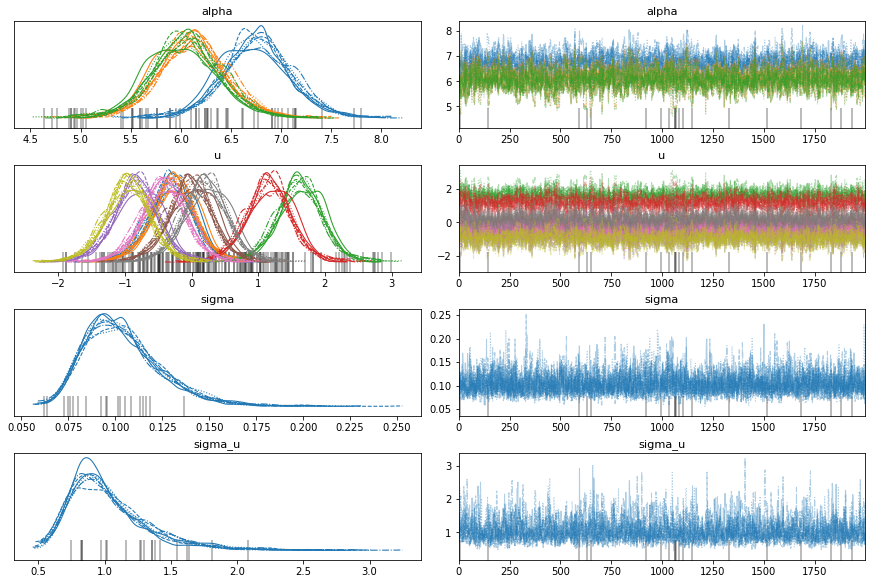

In [29]:
az.plot_trace(fit, var_names = ['alpha', 'u', 'sigma', 'sigma_u']);

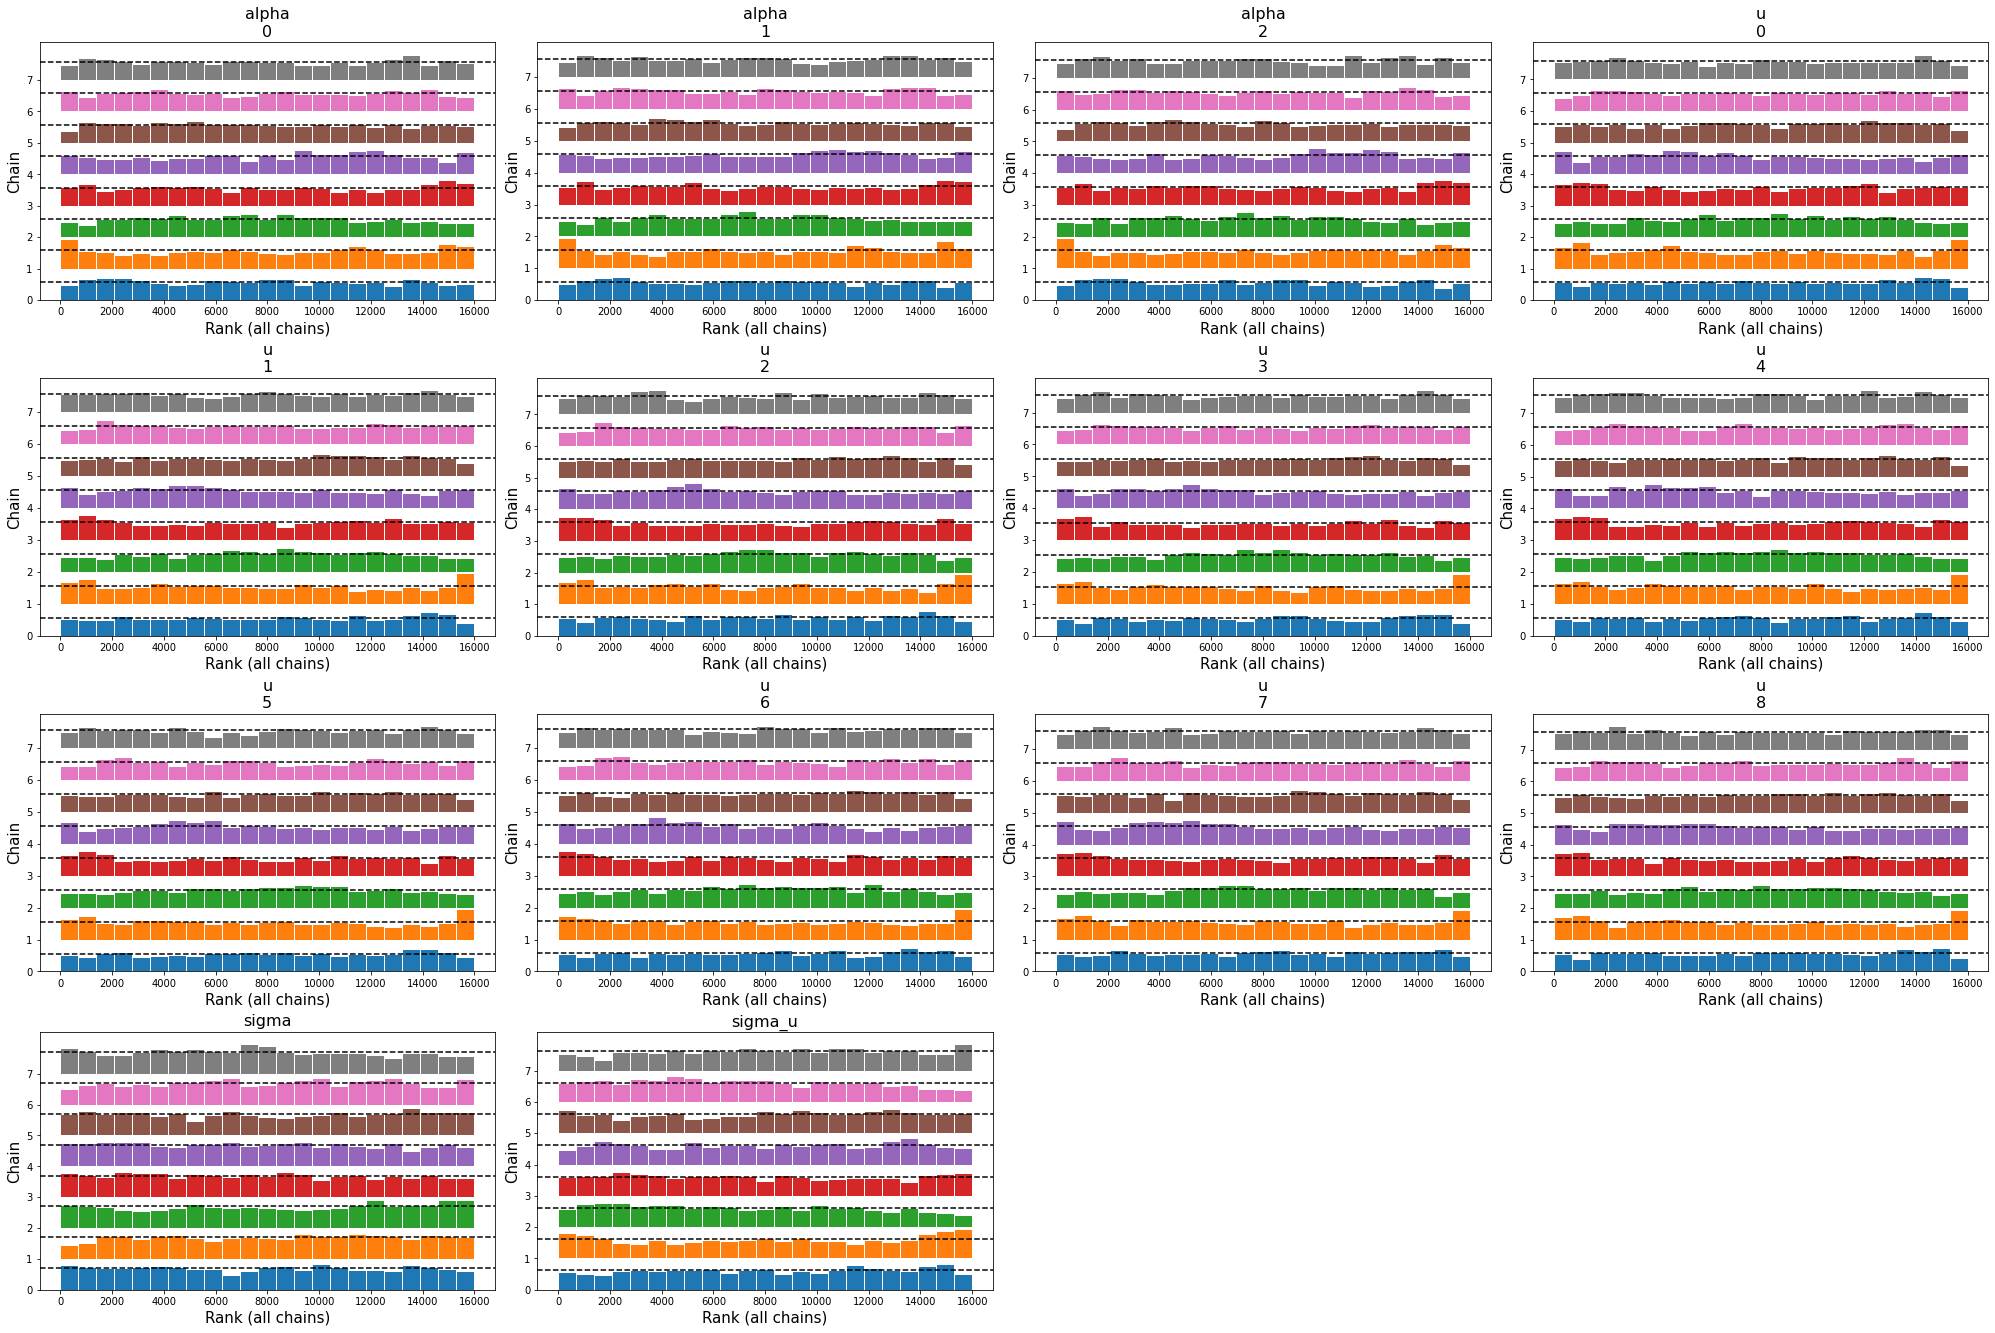

In [25]:
az.plot_rank(fit, var_names = ['alpha', 'u', 'sigma', 'sigma_u']);